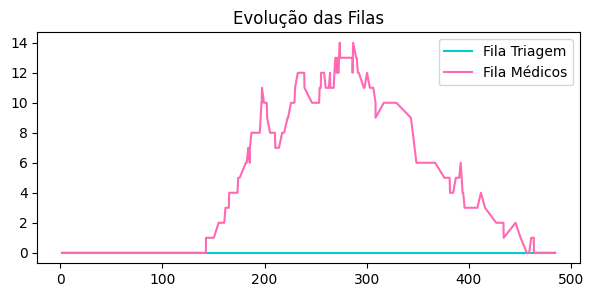

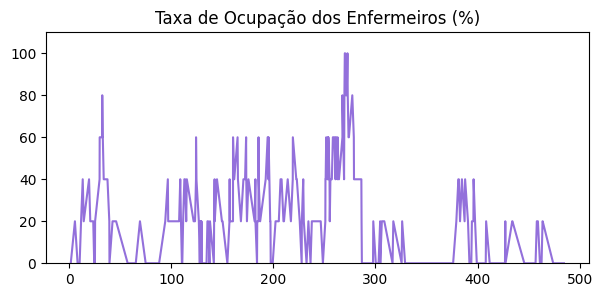

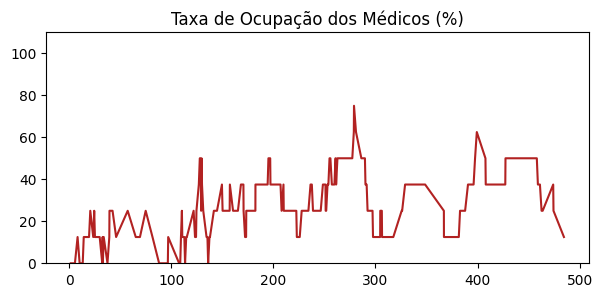

In [10]:
import FreeSimpleGUI as sg
import heapq
import random
import numpy as np
import json
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import io
import sys


# Configurar tema do PySimpleGUI
sg.theme('LightBlue3')

#Atribuição de pulseiras aos doentes
def atribuir_pulseira():
    cores = ["verde", "amarela", "vermelha"]   # distribuição das pulseiras
    pesos_pulseiras = [0.7, 0.2, 0.1]
    return random.choices(cores, weights=pesos_pulseiras, k=1)[0]


#for pessoa in pessoas:  # acrescentar pulseira a cada pessoa
    #pessoa["pulseira"] = atribuir_pulseira()

#with open("pessoas_com_pulseira.json", "w", encoding="utf-8") as f:   # guardar o ficheiro alterado
    #json.dump(pessoas, f, indent=4, ensure_ascii=False)


#Atribuição de especialidades aos doentes
especialidades = [
    "Medicina Geral",
    "Ortopedia",
    "Gastroenterologia",
    "Cardiologia",
    "Neurologia",
    "Psiquiatria"
]

pesos = [
    0.35,  # Medicina Geral 
    0.20,  # Ortopedia
    0.15,  # Gastroenterologia
    0.15,  # Cardiologia
    0.10,  # Neurologia
    0.05   # Psiquiatria 
]

pesos_medicos= [
    0.30,  # Medicina Geral 
    0.20,  # Ortopedia
    0.15,  # Gastroenterologia
    0.20,  # Cardiologia
    0.10,  # Neurologia
    0.05   # Psiquiatria 
]

def atribuir_especialidade():
    return random.choices(especialidades, weights=pesos, k=1)[0]


#for pessoa in pessoas:  #acrescentar especialidade
    #pessoa["especialidade"] = atribuir_especialidade()

#with open("pessoas_com_pulseira_e_especialidade.json", "w", encoding="utf-8") as f: #guardar ficheiro
    #json.dump(pessoas, f, indent=4, ensure_ascii=False)


# Funções de manipulação de eventos
# Evento = (tempo: Float, tipo: String, doente: String)
def e_tempo(e):
    return e[0]

def e_tipo(e):
    return e[1]

def e_doente(e):   #é o id do doente
    return e[2]

# Funções de manipulação para a Queue de Eventos
# queueEventos = [Evento]
def procuraPosQueue(q, t):
    i = 0
    while i < len(q) and t > q[i][0]:
        i = i + 1
    return i

def enqueue(q, e):
    pos = procuraPosQueue(q, e[0])
    return q[:pos] + [e] + q[pos:]

def dequeue(q):
    e = q[0]
    q = q[1:]
    return e, q

# Funções de manipulação de médicos
# Médico = [id: String, ocupado: Boolean, doente_corrente: String, total_tempo_ocupado: Float, inicio_ultima_consulta: Float, Especialidade: String]
def m_id(e):
    return e[0]

def m_ocupado(e):
    return e[1]

def mOcupa(m):
    m[1] = not m[1]
    return m

def m_doente_corrente(e):
    return e[2]

def mDoenteCorrente(m, d):
    m[2] = d
    return m

def m_total_tempo_ocupado(e):
    return e[3]

def mTempoOcupado(m, t):
    m[3] = t
    return m

def m_inicio_ultima_consulta(e):
    return e[4]

def mInicioConsulta(m, t):
    m[4] = t
    return m 

def m_especialidade(e):
    return e[5]

# Funções de manipulação de emfermeiros
# Enfermeiro = [id: String, ocupado: Boolean, doente_corrente: String, total_tempo_ocupado: Float, inicio_ultima_triagem: Float]
def enf_id(e):
    return e[0]         

def enf_ocupado(e):
    return e[1] 

def enfOcupa(enf):
    enf[1] = not enf[1]
    return enf

def enf_doente_corrente(e):
    return e[2]

def enfDoenteCorrente(enf, d):
    enf[2] = d
    return enf

def enf_total_tempo_ocupado(e):
    return e[3]

def enfTempoOcupado(enf, t):
    enf[3] = t
    return enf

def enf_inicio_ultima_triagem(e):
    return e[4]

def enfInicioTriagem(enf, t):
    enf[4] = t
    return enf


# Utilização das distribuições para gerar chegadas e durações das consultas
def gera_intervalo_tempo_chegada(lmbda):
    return np.random.exponential(1 / lmbda)

def gera_tempo_triagem(TEMPO_MEDIO_TRIAGEM):
    return np.random.exponential(TEMPO_MEDIO_TRIAGEM)

def gera_tempo_consulta(DISTRIBUICAO_TEMPO_CONSULTA,TEMPO_MEDIO_CONSULTA):
    if DISTRIBUICAO_TEMPO_CONSULTA == "exponential":
        return np.random.exponential(TEMPO_MEDIO_CONSULTA)
    elif DISTRIBUICAO_TEMPO_CONSULTA == "normal":
        return max(0, np.random.normal(TEMPO_MEDIO_CONSULTA, 5))
    elif DISTRIBUICAO_TEMPO_CONSULTA == "uniform":
        return np.random.uniform(TEMPO_MEDIO_CONSULTA * 0.5, TEMPO_MEDIO_CONSULTA * 1.5)

# Funções auxiliares
# Procura o primeiro médico livre
def procuraMedico(lista):
    res = None
    i = 0
    encontrado = False
    while not encontrado and i < len(lista):
        if not lista[i][1]:
            res = lista[i]
            encontrado = True
        i= i + 1
    return res

# FUNÇÃO DE SIMULAÇÃO PARA A INTERFACE

def simula_interface(params):
    # Variável para acumular as mensagens do log
    log_texto = ""

    # Parâmetros da interface
    NUM_ENFERMEIROS = params['NUM_ENFERMEIROS']
    NUM_MEDICOS = params['NUM_MEDICOS']
    TAXA_CHEGADA = params['TAXA_CHEGADA'] / 60
    TEMPO_MEDIO_TRIAGEM = params['TEMPO_MEDIO_TRIAGEM']
    TEMPO_MEDIO_CONSULTA = params['TEMPO_MEDIO_CONSULTA']
    TEMPO_SIMULACAO = params['TEMPO_SIMULACAO']
    DISTRIBUICAO_TEMPO_CONSULTA = params['DISTRIBUICAO']

    CHEGADA = "chegada"
    FIM_TRIAGEM = "fim_triagem"
    SAIDA = "saída"

    with open("pessoas.json", "r", encoding="utf-8") as f:      # ler o ficheiro original
        pessoas = json.load(f)

    doentes = {}
    tempo_atual = 0.0
    contadorDoentes = 1
    queueEventos = [] # Lista de eventos que vão acontecer, ordenada por tempo de ocorrência do evento
    fila_triagem=[]
    queue = [] # Fila de espera dos médicos - doentes à espera de médico disponível

    # Geração da lista de enfermeiros
    enfermeiros=[]
    for i in range (NUM_ENFERMEIROS):
        enfermeiros.append([f"e{i+1}", False, None, 0.0, 0.0]) 
        # [id, ocupado, doente_corrente, total_tempo_ocupado, inicio_ultima_triagem]    

    # Geração da lista de médicos
    medicos = []
    for i in range(NUM_MEDICOS):
        if i < len(especialidades):
            esp = especialidades[i]
        else:
            esp = random.choices(especialidades, weights=pesos_medicos, k=1)[0]
        # [id, ocupado, doente_corrente, total_tempo_ocupado, inicio_ultima_consulta, Especialidade]
        medicos.append([f"m{i+1}", False, None, 0.0, 0.0, esp])

    # Mostrar as especialidades dos médicos (apenas uma vez no final da inicialização)
    print("-" * 40)
    print(f"{'Médico':<10} | {'Especialidade':<20}")
    print("-" * 40)
    for medico in medicos:
        print(f"{m_id(medico):<10} | {m_especialidade(medico):<20}")
    print("-" * 40)
    print("\n")

    # Cabeçalho da tabela de eventos
    print("-" * 95)
    print(f"{'Evento':<12} | {'Tempo':<8} | {'Doente':<8} | {'Detalhes':<55}")
    print("-" * 95)

    # Dicionário para registar qual médico atendeu cada doente
    atendimentos = {}  # {doente_id: medico_id}

    prioridades_cores = {"vermelha": 1, "amarela": 2, "verde": 3}

    # Listas para os gráficos
    h_t, h_f_tri, h_f_med, h_oc_med, h_oc_enf = [], [], [], [], []

 
    # Geração das chegadas de doentes
    # chegadas = {} # dicionário de suporte para a geração das consultas
    
    tempo_atual = tempo_atual + gera_intervalo_tempo_chegada(TAXA_CHEGADA)
    while tempo_atual < TEMPO_SIMULACAO:
        doente_id = "p" + str(contadorDoentes) #troquei para p
        contadorDoentes += 1
        #chegadas[doente_id] = tempo_atual
        queueEventos = enqueue(queueEventos, (tempo_atual, CHEGADA, doente_id))
        tempo_atual = tempo_atual + gera_intervalo_tempo_chegada(TAXA_CHEGADA)

    # Tratamento dos eventos
    doentes_atendidos = 0

    while queueEventos != []:
        evento, queueEventos = dequeue(queueEventos)
        tempo_atual = e_tempo(evento)

        # Captura de dados para gráficos
        h_t.append(tempo_atual)
        h_f_tri.append(len(fila_triagem))
        h_f_med.append(len(queue))
        h_oc_med.append((sum(1 for m in medicos if m[1]) / NUM_MEDICOS) * 100 if NUM_MEDICOS > 0 else 0)
        h_oc_enf.append((sum(1 for e in enfermeiros if e[1]) / NUM_ENFERMEIROS) * 100 if NUM_ENFERMEIROS > 0 else 0)

        if e_tipo(evento) == CHEGADA:
            doente_id = e_doente(evento)    #e_doente(evento) é o id do doente
            for pessoa in pessoas:
                if pessoa["id"] == doente_id: 
                    doentes[doente_id] = pessoa  #guarda no dicionario a pessoa que deu match pelo id

            print(f"{'CHEGADA':<12} | {e_tempo(evento):<8.2f} | {doente_id:<8} | {'Entrou na clínica':<55}")

            # Procurar enfermeiro livre com MENOR tempo de ocupação (para equilibrar a carga)
            enf_index = -1
            min_tempo_ocupado = 999999
            
            i = 0
            while i < len(enfermeiros):
                if not enf_ocupado(enfermeiros[i]):
                    tempo_ocupado = enf_total_tempo_ocupado(enfermeiros[i])
                    if tempo_ocupado < min_tempo_ocupado:
                        min_tempo_ocupado = tempo_ocupado
                        enf_index = i
                i = i + 1
            
            if enf_index != -1:
                # Há enfermeiro disponível - iniciar triagem imediatamente
                enfermeiros[enf_index] = enfOcupa(enfermeiros[enf_index])
                enfermeiros[enf_index] = enfDoenteCorrente(enfermeiros[enf_index], doente_id)
                enfermeiros[enf_index] = enfInicioTriagem(enfermeiros[enf_index], tempo_atual)

                # Gerar evento de fim de triagem
                t_triagem = gera_tempo_triagem(TEMPO_MEDIO_TRIAGEM)
                queueEventos = enqueue(queueEventos, (tempo_atual + t_triagem, FIM_TRIAGEM, doente_id))
                print(f"{'TRIAGEM':<12} | {tempo_atual:<8.2f} | {doente_id:<8} | {f'Iniciou triagem com {enf_id(enfermeiros[enf_index])}':<55}")
            else:
                # Não há enfermeiro disponível - adicionar à fila de triagem
                fila_triagem.append((doente_id, tempo_atual))
                print(f"{'ESPERA':<12} | {tempo_atual:<8.2f} | {doente_id:<8} | {f'Aguarda triagem (Fila: {len(fila_triagem)})':<55}")
        
        elif e_tipo(evento) == FIM_TRIAGEM:
            doente_id = e_doente(evento)
            print(f"{'FIM TRIAGEM':<12} | {e_tempo(evento):<8.2f} | {doente_id:<8} | {'Terminou triagem':<55}")

            # Vamos libertar o enfermeiro e despachar o doente
            i = 0
            encontrado = False
            enf_index = -1
            while i < len(enfermeiros) and not encontrado:
                if enf_doente_corrente(enfermeiros[i]) == doente_id:
                    enf_index = i
                    enfermeiros[i] = enfOcupa(enfermeiros[i])
                    enfermeiros[i] = enfDoenteCorrente(enfermeiros[i], None)
                    enfermeiros[i] = enfTempoOcupado(enfermeiros[i], enf_total_tempo_ocupado(enfermeiros[i]) + tempo_atual - enf_inicio_ultima_triagem(enfermeiros[i]))
                    encontrado = True
                i = i + 1
            
            # Atribuir pulseira e especialidade AGORA
            doentes[doente_id]["pulseira"] = atribuir_pulseira()
            doentes[doente_id]["especialidade"] = atribuir_especialidade()
            prio_nome = doentes[doente_id]["pulseira"]
            esp_nome = doentes[doente_id]["especialidade"]

            print(f"{'TRIADO':<12} | {tempo_atual:<8.2f} | {doente_id:<8} | {f'Triado: {prio_nome} | {esp_nome}':<55}")


            #Atribuir médico ao doente
            atendido = False
            pessoa = doentes[doente_id]   #acede às informações todas (nomeadamente a pulseira e a especialidade) do paciente conforme o seu id

            for i in range(len(medicos)):
                medico = medicos[i] #esta linha é usada no if, em baixo

                if (medico[1] == False and medico[5] == pessoa['especialidade'] and not atendido):
                    medicos[i] = mOcupa(medico)
                    medicos[i] = mInicioConsulta(medicos[i], tempo_atual)
                    medicos[i] = mDoenteCorrente(medicos[i], doente_id)
                    atendimentos[doente_id] = m_id(medico)
                    tempo_consulta = gera_tempo_consulta(DISTRIBUICAO_TEMPO_CONSULTA, TEMPO_MEDIO_CONSULTA)
                    queueEventos = enqueue(queueEventos, (tempo_atual + tempo_consulta, SAIDA, doente_id))
                    atendido = True
                    print(f"{'ATENDIDO':<12} | {tempo_atual:<8.2f} | {doente_id:<8} | {f'Atendido por {m_id(medico)} ({m_especialidade(medico)})':<55}") 

            if not atendido:
                queue.append((doente_id, tempo_atual))
                print(f"{'ESPERA':<12} | {tempo_atual:<8.2f} | {doente_id:<8} | {f'Aguarda médico (Fila: {len(queue)})':<55}")
        
        elif e_tipo(evento) == SAIDA:
            doente_id = e_doente(evento)
            pessoa = doentes[doente_id]
            
            # Libertar o médico
            i = 0
            encontrado = False
            medico_index = -1  #ainda não sabemos qual é o médico
            
            while i < len(medicos) and not encontrado:
                if m_doente_corrente(medicos[i]) == doente_id:
                    medico_index = i  #atualizamos o medico_index para o i do médico atual
                    medicos[i] = mOcupa(medicos[i])
                    medicos[i] = mDoenteCorrente(medicos[i], None)
                    medicos[i] = mTempoOcupado(medicos[i], m_total_tempo_ocupado(medicos[i]) + tempo_atual - m_inicio_ultima_consulta(medicos[i]))
                    encontrado = True
                i = i + 1
            
            print(f"{'SAÍDA':<12} | {e_tempo(evento):<8.2f} | {doente_id:<8} | {f'Saiu da clínica ({pessoa['especialidade']})':<55}")
            doentes_atendidos += 1


            # Se um médico ficou livre, procurar na fila o doente com MAIOR PRIORIDADE e mesma especialidade
            if medico_index != -1:   #se encontramos médico
                medico = medicos[medico_index]  #ver quem é o médico, segundo o seu index
                esp_medico = m_especialidade(medico)
                
                # Procurar o melhor doente na fila (maior prioridade, depois tempo de chegada)
                melhor_doente_id = -1  #começamos sem ninguém escolhido
                min_prioridade = 999   #usamos 999 para que qualquer prioridade real (1, 2 ou 3) seja menor
                min_tempo = 999999    #usamos 999 para que qualquer prioridade real (1, 2 ou 3) seja menor
                
                j = 0
                while j < len(queue):  #percorre cada pessoa na fila
                    d_id, t_chegada = queue[j]  #pegamos no ID e no tempo de quem está na posição 'j'
                    p_fila = doentes[d_id]    #vamos buscar a ficha completa dessa pessoa
                    
                    if p_fila['especialidade'] == esp_medico:
                        prio = prioridades_cores[p_fila['pulseira']]  #vemos a prioridade (Vermelha=1, Amarela=2, Verde=3)

                        # Se encontrarmos um doente com maior prioridade OU mesma prioridade mas chegou antes
                        if prio < min_prioridade or (prio == min_prioridade and t_chegada < min_tempo):
                            min_prioridade = prio
                            min_tempo = t_chegada
                            melhor_doente_id = j
                    j += 1
                
                if melhor_doente_id != -1:
                    # Retirar o doente da fila
                    prox_doente_id = queue[melhor_doente_id][0]  #pegamos no id do doente com maior prioridade
                    queue = queue[:melhor_doente_id] + queue[melhor_doente_id+1:]  #tira a pessoa da fila, juntando o que estava antes e depois dela
                    
                    # Ocupar o médico
                    medicos[medico_index] = mOcupa(medicos[medico_index])
                    medicos[medico_index] = mInicioConsulta(medicos[medico_index], tempo_atual)
                    medicos[medico_index] = mDoenteCorrente(medicos[medico_index], prox_doente_id)
                    
                    tempo_consulta = gera_tempo_consulta(DISTRIBUICAO_TEMPO_CONSULTA, TEMPO_MEDIO_CONSULTA)
                    queueEventos = enqueue(queueEventos, (tempo_atual + tempo_consulta, SAIDA, prox_doente_id))
                    
                    print(f"{'FILA':<12} | {tempo_atual:<8.2f} | {prox_doente_id:<8} | {f'Atendido da fila por {m_id(medico)}':<55}")
            
    return {
        'atendidos': doentes_atendidos,
        'medicos': medicos,
        'enfermeiros': enfermeiros,
        'historico': {'t': h_t, 'f_tri': h_f_tri, 'f_med': h_f_med, 'oc_med': h_oc_med, 'oc_enf': h_oc_enf}
    }



    #print("\nESTATÍSTICAS DOS ENFERMEIROS:")
    #for enf in enfermeiros:
     #   print(f"  {enf_id(enf)}:")
     #   print(f"    Tempo total ocupado: [t={enf_total_tempo_ocupado(enf):6.2f}]")
     #   print(f"    Taxa de ocupação: {(enf_total_tempo_ocupado(enf) / TEMPO_SIMULACAO) * 100:6.2f}%")

    #print("\nESTATÍSTICAS DOS MÉDICOS:")
    #for m in medicos:
     #  print(f"  {m_id(m)} ({m_especialidade(m)}):")
     #  print(f"    Tempo total ocupado: [t={m_total_tempo_ocupado(m):6.2f}]")
     #  print(f"    Taxa de ocupação: {(m_total_tempo_ocupado(m) / TEMPO_SIMULACAO) * 100:6.2f}%")


# INTERFACE GRÁFICA

def draw_figure(canvas, figure):
    figure_canvas_agg = FigureCanvasTkAgg(figure, canvas)
    figure_canvas_agg.draw()
    figure_canvas_agg.get_tk_widget().pack(side='top', fill='both', expand=1)
    return figure_canvas_agg

def main():
    layout = [
        [sg.Text('SIMULAÇÃO DE CLÍNICA MÉDICA', font=('Arial', 18, 'bold'))],
        [sg.Text('Configurações:', font=('Arial', 12, 'bold'))],
        [sg.Text('Enfermeiros:'), sg.Input('5', key='ENF', size=(5,1)), sg.Text('Médicos:'), sg.Input('8', key='MED', size=(5,1))],
        [sg.Text('Taxa Chegada (pac/h):'), sg.Input('10', key='TAXA', size=(5,1)), sg.Text('Duração (min):'), sg.Input('480', key='DUR', size=(5,1))],
        [sg.Text('Tempo Triagem (min):'), sg.Input('5', key='T_TRI', size=(5,1)), sg.Text('Tempo Consulta (min):'), sg.Input('15', key='T_CONS', size=(5,1))],
        [sg.Text('Distribuição:'), sg.Combo(['exponential', 'normal', 'uniform'], default_value='exponential', key='DIST')],
        [sg.Button('EXECUTAR SIMULAÇÃO', size=(30, 2), button_color=('black', 'lightyellow'), key='EXEC'), sg.Button('SAIR', size=(10, 2))],
        [sg.TabGroup([[
            sg.Tab('Log', [[sg.Multiline(size=(100, 10), key='LOG', font='Courier 10', autoscroll=True, disabled=True)]]),
            sg.Tab('Estatísticas', [[sg.Multiline(size=(100, 10), key='STATS', font='Courier 10', disabled=True)]]),
            sg.Tab('Gráficos', [[sg.Column([[sg.Canvas(key='CANVAS_FILA', size=(600, 250))], [sg.Canvas(key='CANVAS_OCUP_ENF', size=(600, 250))], [sg.Canvas(key='CANVAS_OCUP_MED', size=(600, 250))]], scrollable=True, vertical_scroll_only=True, size=(800, 400))]])
        ]])]
    ]

    # Criar a janela
    window = sg.Window('Clínica Médica', layout, size=(900, 550), finalize=True, resizable=True)
    canvas_fila, canvas_ocup_enf, canvas_ocup_med = None, None, None

    # Loop de eventos
    stop = False
    while not stop:
        event, values = window.read()

        # Fecha a aplicação
        if event in (sg.WIN_CLOSED, 'SAIR'):
            stop = True

        # Executa a simulação
        if event == 'EXEC':
            # Validação de inputs numéricos
            erro_input = False
            try:
                # Primeiro tentamos converter tudo para float para ver se são números
                f_enf = float(values['ENF'])
                f_med = float(values['MED'])
                taxa = float(values['TAXA'])
                t_tri = float(values['T_TRI'])
                t_cons = float(values['T_CONS'])
                duracao = float(values['DUR'])
                
                # Verificamos quais campos devem ser inteiros
                if not f_enf.is_integer() or not f_med.is_integer() or not taxa.is_integer() or not duracao.is_integer():
                    sg.popup_error("Erro: Enfermeiros, Médicos, Taxa e Duração devem ser números inteiros!", title="Erro de Formato")
                    erro_input = True
                else:
                    num_enf = int(f_enf)
                    num_med = int(f_med)
                    num_taxa = int(taxa)
                    num_duracao = int(duracao)
            except ValueError:
                sg.popup_error("Erro: Por favor, introduza apenas números nos campos de configuração!", title="Erro de Input")
                erro_input = True
            
            if not erro_input:
                params = {
                    'NUM_ENFERMEIROS': num_enf,
                    'NUM_MEDICOS': num_med,
                    'TAXA_CHEGADA': num_taxa,
                    'TEMPO_MEDIO_TRIAGEM': t_tri,
                    'TEMPO_MEDIO_CONSULTA': t_cons,
                    'TEMPO_SIMULACAO': num_duracao,
                    'DISTRIBUICAO': values['DIST']
                }
            
                # Capturar o output para o log
                old_stdout = sys.stdout
                sys.stdout = io.StringIO()
                
                res = simula_interface(params)
                
                log_capturado = sys.stdout.getvalue()
                sys.stdout = old_stdout
                
                # Atualizar a interface com os resultados
                window['LOG'].update(disabled=False)
                window['LOG'].update(log_capturado)
                window['LOG'].update(disabled=True)
                
                stats = "ESTATÍSTICAS ENFERMEIROS:\n"
                for e in res['enfermeiros']:
                    taxa = (e[3] / params['TEMPO_SIMULACAO']) * 100
                    stats += f"  {e[0]}: Ocupação {taxa:6.2f}%\n"
                
                stats += "\nESTATÍSTICAS MÉDICOS:\n"
                for m in res['medicos']:
                    taxa = (m[3] / params['TEMPO_SIMULACAO']) * 100
                    stats += f"  {m[0]} ({m[5]:<18}): {taxa:6.2f}%\n"
                
                window['STATS'].update(disabled=False)
                window['STATS'].update(stats)
                window['STATS'].update(disabled=True)

                # Atualizar os gráficos
                if canvas_fila: 
                    canvas_fila.get_tk_widget().destroy()
                if canvas_ocup_enf: 
                    canvas_ocup_enf.get_tk_widget().destroy()
                if canvas_ocup_med: 
                    canvas_ocup_med.get_tk_widget().destroy()

                # Gráfico das Filas
                fig1, ax1 = plt.subplots(figsize=(7, 3))
                ax1.plot(res['historico']['t'], res['historico']['f_tri'], label='Fila Triagem', color='darkturquoise')
                ax1.plot(res['historico']['t'], res['historico']['f_med'], label='Fila Médicos', color='hotpink')
                ax1.set_title('Evolução das Filas')
                ax1.legend()
                canvas_fila = draw_figure(window['CANVAS_FILA'].TKCanvas, fig1)

                # Gráfico Ocupação Enfermeiros
                fig2, ax2 = plt.subplots(figsize=(7, 3))
                #print(res['historico'].keys(),flush=True)
                ax2.plot(res['historico']['t'], res['historico']['oc_enf'], color='mediumpurple')
                ax2.set_title('Taxa de Ocupação dos Enfermeiros (%)')
                ax2.set_ylim(0, 110)
                canvas_ocup_enf = draw_figure(window['CANVAS_OCUP_ENF'].TKCanvas, fig2)

                # Gráfico Ocupação Médicos
                fig3, ax3 = plt.subplots(figsize=(7, 3))
                ax3.plot(res['historico']['t'], res['historico']['oc_med'], color='firebrick')
                ax3.set_title('Taxa de Ocupação dos Médicos (%)')
                ax3.set_ylim(0, 110)
                canvas_ocup_med = draw_figure(window['CANVAS_OCUP_MED'].TKCanvas, fig3)

    # Fechar a janela
    window.close()

if __name__ == '__main__':
    main()